In [1]:
import plotly.express as px
import numpy as np
from tqdm import tqdm
import pandas as pd

from scipy.spatial import distance_matrix
from sklearn.manifold import MDS

from matplotlib import pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import os
from MPSE.MPSE import mview
from utils import *

# import pyvista as pv

%matplotlib inline

2023-03-01 15:29:16.249391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 15:29:16.368444: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-01 15:29:16.375591: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/insane/.cache/pypoetry/virtualenvs/3d-reconstruction-mtYbvF5z-py3.10/lib/python3.10/site-p

In [2]:
pix3D_dataset = [
    'Pix3D:chair:0132',
    'Pix3D:chair:1582',
    'Pix3D:sofa:0912',
    'Pix3D:table:0777',
    'Pix3D:table:1665',
    'Pix3D:sofa:0909',
]

In [5]:
pix3d_datadir = '/run/media/insane/My 4TB 2/Big Data/MPSE/Data/pix3d/'
shapened_datadir = '/run/media/insane/My 4TB 2/Big Data/MPSE/Data/ShapeNetCore/ShapeNetCore.v2'
modelnet_datadir = None

# dataset = "ShapeNet:airplane:4b4fd540cab0cdf3f38bce64a8733419"
dataset = "ModelNet10:chair:0003"
# dataset = pix3D_dataset[0]

points = get_dataset_points(dataset, datadir=modelnet_datadir, n_points=512, normalize=True)

plot_3D_paper([apply_transformation(points, getRotationMatrix(0, 'y'))]).show()

/home/insane/.keras/datasets/ModelNet10/chair/train/chair_0003.off


In [4]:
object_name = "chair"
object_idx = "0002"
datadir = load_modelnet()
# _, object_name, object_idx = dataset.split(':')
obj_path = os.path.join('/'.join(datadir.split('/')[:-1]), f"ModelNet10/{object_name}/train/{object_name}_{object_idx}.off")
print(obj_path)
mesh = trimesh.load(obj_path)
mesh.show()

/home/insane/.keras/datasets/ModelNet10/chair/train/chair_0002.off


In [ ]:
# cloud = pv.PolyData(points)
# cloud.plot(jupyter_backend='pythreejs')
# cloud.plot(jupyter_backend='ipygany')
# volume = cloud.delaunay_3d(alpha=0.1)
# shell = volume.extract_geometry()
# shell.plot(jupyter_backend='ipygany')

In [7]:
def ray_traceZ(points, radius):
    only_points = np.array([point['data'] for point in sorted(points, key=lambda x: x['id'])])
    visible_points = []
    for i, p1 in enumerate(only_points):
        visible = True
        for p2 in only_points:
            if p1 is not p2 and p1[2] > p2[2]:
                if np.linalg.norm(p1 - p2) < radius:
                    visible = False
                    
        if visible:
            visible_points.append({
                'id': i,
                'data': p1
            })
    
    return visible_points

In [18]:
def add_matching_noise(perspectives, p=0.01, q=0.01):
    n = len(perspectives[0])
    noise_points1 = np.random.choice(n, int(p*n), replace=False)

    perspectives = np.array(perspectives)

    for noise_point1 in noise_points1:
        perspective_i = np.random.choice(len(perspectives), 1, replace=False)[0]
        # Sort the points by distance to the noise point. Also exclude the z coordinate
        dists = np.linalg.norm(perspectives[perspective_i, :, :2] - perspectives[perspective_i, noise_point1, :2], axis=1)
        noise_points2 = np.argsort(dists)[:int(q*n)]
        noise_point2 = np.random.choice(noise_points2, 1, replace=False)[0]
        perspectives[perspective_i, [noise_point1, noise_point2]] = perspectives[perspective_i, [noise_point2, noise_point1]]

    return perspectives


In [8]:
labeled_perspectives = []
perspectives, projection_mats = get_randomized_all_persps(points, 5, angleRange=[0, 360])
# Here is where I want to add permutation noise. But I can't change the order of perspectives
perspectives = add_matching_noise(perspectives, p=0.01, q=0.01)
for perspective in perspectives:
    labeled_perspectives.append(give_ids(perspective))

proj = 'n_persp'
if proj == 'n_persp':
    labeled_perspectives = visible_in_n_persp(labeled_perspectives, 5)
elif proj == 'ray':
    labeled_perspectives = [
        # ray_traceZ(p, n_raysX=200, n_raysY=200) for p in tqdm(labeled_perspectives)
        ray_traceZ(p, 0.05) for p in tqdm(labeled_perspectives)
    ]

[len(i) for i in labeled_perspectives]

[512, 512, 512, 512, 512]

In [9]:
plot_3D([add_col(remove_ids(labeled_perspectives[1]))]).show()

In [10]:
# Set z to 0 for each point
for labeled_perspective in labeled_perspectives:
    for p in labeled_perspective:
        p['data'][2] = 0

plot_3D([add_col(remove_ids(labeled_perspectives[4]))]).show()

In [15]:
dist_mats, weights_mats = get_dist_weights(labeled_perspectives, len(points), ndim=2)

add_noise(dist_mats, 0.1)

5it [00:44,  8.94s/it]


In [16]:
dist_mats[0].shape

(2048, 2048)

In [17]:

points_per_persp = np.array(show_points_least_persp(weights_mats))
points_per_persp = points_per_persp/points_per_persp.max() * 100

fig = px.bar(points_per_persp, x=range(1, len(points_per_persp)+1), y=points_per_persp, title="Points per Perspective")
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [18]:
baseline = get_baseline_metrics(points, dist_mats)
print('Chamfer:', baseline['chamfer'])
print('EMD:', baseline['EMD'])
# plot_3D([apply_transformation(embeddings, trans_mat), points], colors=['green', 'red'])

# plot_3D([embeddings]).show()

4 Point Alignment: 100%|██████████| 10000/10000 [00:02<00:00, 4569.21it/s]


Chamfer: 2.0010620437962756
EMD: 1.4290324544801511


mview.MPSE():
  data details:
    number of perspectives : 8
    number of samples : 2048
  visualization details:
    embedding dimension : 3
    image dimension : 2
    visualization type : mds
  setup visualization instance for perspective 1 :
    mview.MDS():
      data details:
        number of samples : 2048
        weighted : True
      embedding details:
        embedding dimension : 2
    initial embedding : random
    initial stress : 7.61e-01
  setup visualization instance for perspective 2 :
    mview.MDS():
      data details:
        number of samples : 2048
        weighted : True
      embedding details:
        embedding dimension : 2
    initial embedding : random
    initial stress : 7.53e-01
  setup visualization instance for perspective 3 :
    mview.MDS():
      data details:
        number of samples : 2048
        weighted : True
      embedding details:
        embedding dimension : 2
    initial embedding : random
    initial stress : 7.54e-01
  setup visuali

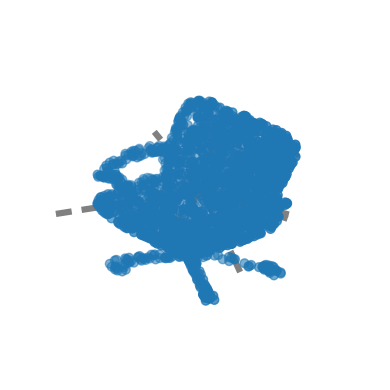

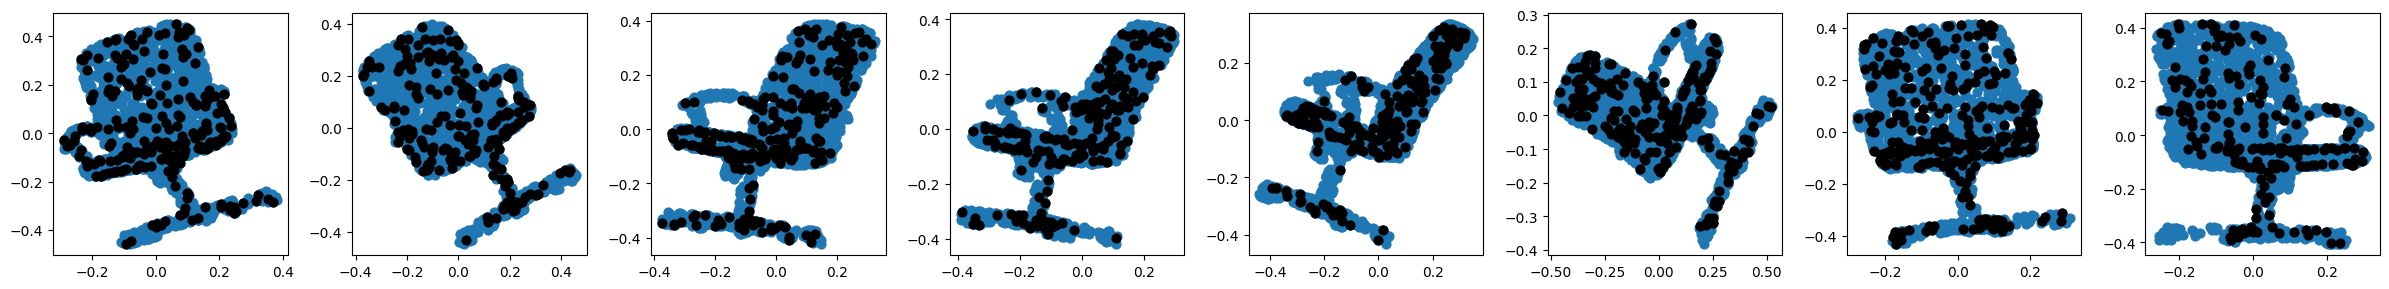

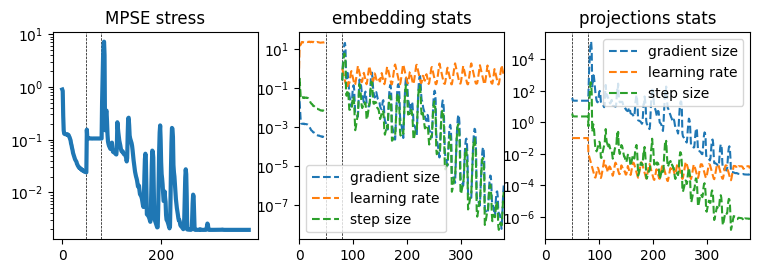

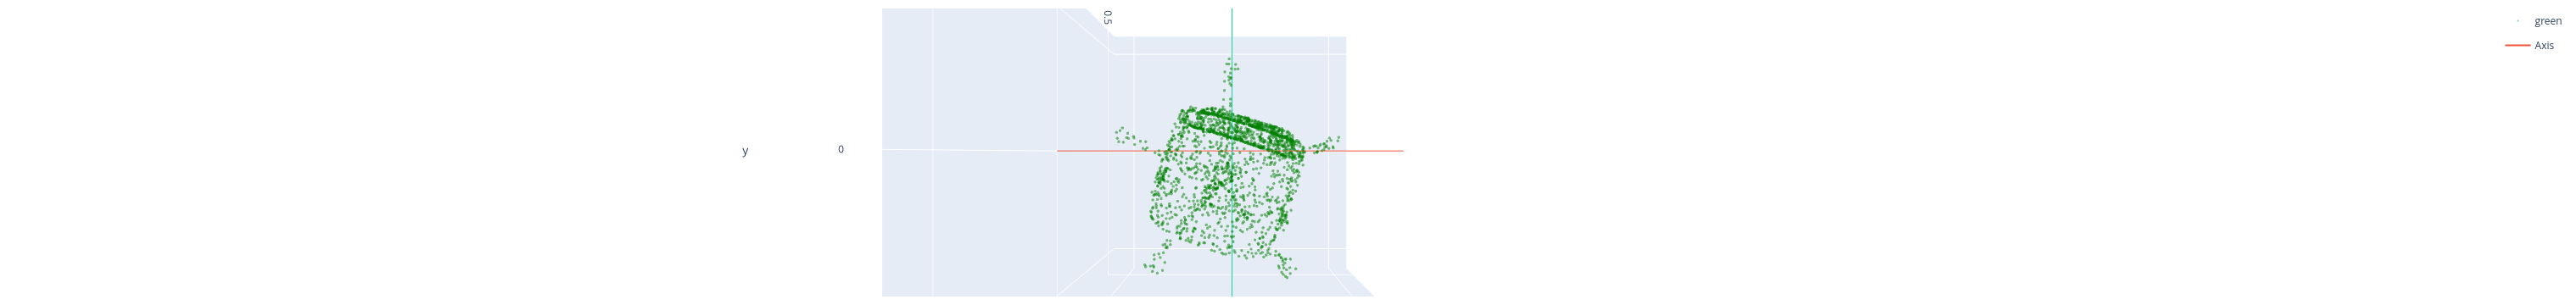

In [13]:
mv = mview.basic(dist_mats.copy(), #
                 batch_size = 2048,
                 max_iter=300, min_grad=1e-4, min_cost=1e-4,
                 verbose=2, 
                 smart_initialization=True,
                 weights=weights_mats.copy(),
                 
                 # For fixed projections
                 # fixed_projections = projection_mats,
                 
                 # For variable projections
                 fixed_projections = None,
                 initial_projections = 'cylinder'
                )

emb_plot = mv.plot_embedding()
imgs_plot = mv.plot_images()
comp_plot = mv.plot_computations()

plt.show()

embeddings = mv.X.copy()
plot_3D([embeddings]).show()

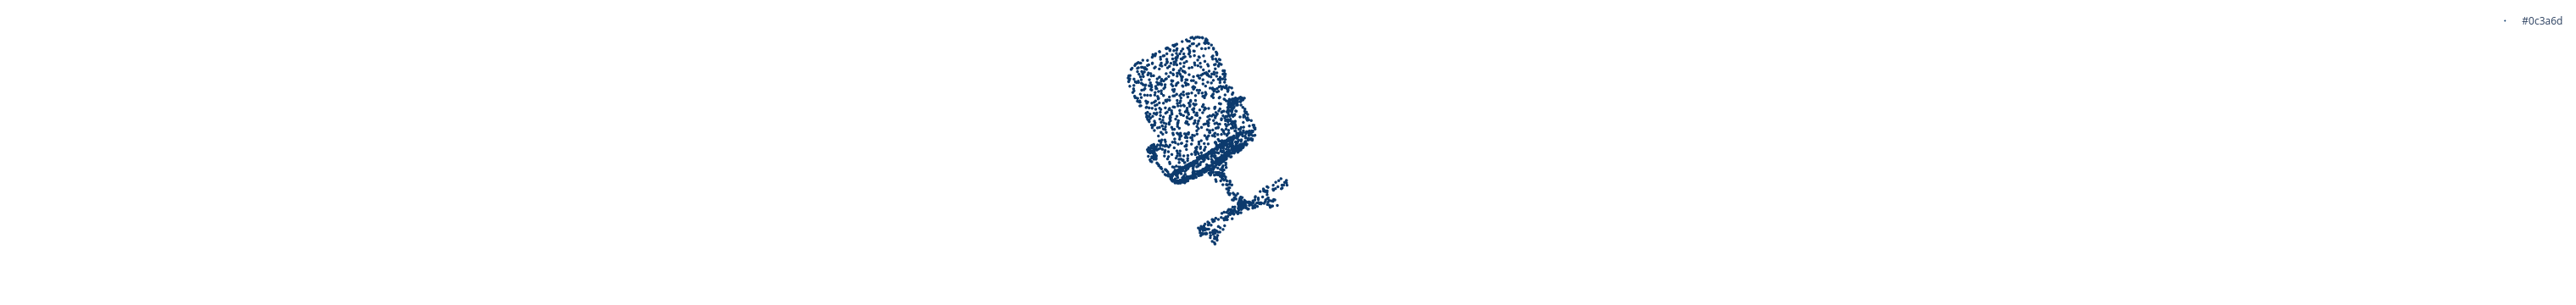

In [14]:
plot_3D_paper([apply_transformation(embeddings, getRotationMatrix(40, 'x'))], point_size=2, colors=['#0c3a6d']).show()

In [ ]:
val = np.unique(np.triu(distance_matrix(embeddings, embeddings)))
val.sort()

px.histogram(val, title="Distance distribution between points")

In [ ]:
rand_embeddings = np.random.rand(*points.shape)
rand_embeddings = (rand_embeddings - rand_embeddings.min()) * (points.max() - points.min()) + points.min()

rand_embeddings.min(), rand_embeddings.max(), rand_embeddings.mean()

In [ ]:
points.min(), points.max(), points.mean()

In [ ]:
chamfer_distance_numpy(np.expand_dims(rand_embeddings, axis=0), np.expand_dims(points, axis=0))

In [ ]:
emd(rand_embeddings, points)

2022-11-18 09:10:56.962350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 09:10:57.080463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 09:10:57.080940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 09:10:57.086832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Chamfer Distance: 3.4475173794757548
Loss: 0.03144894943392435
EMD: 3.141342825690438
CPU times: user 3.63 s, sys: 370 ms, total: 4 s
Wall time: 5.74 s


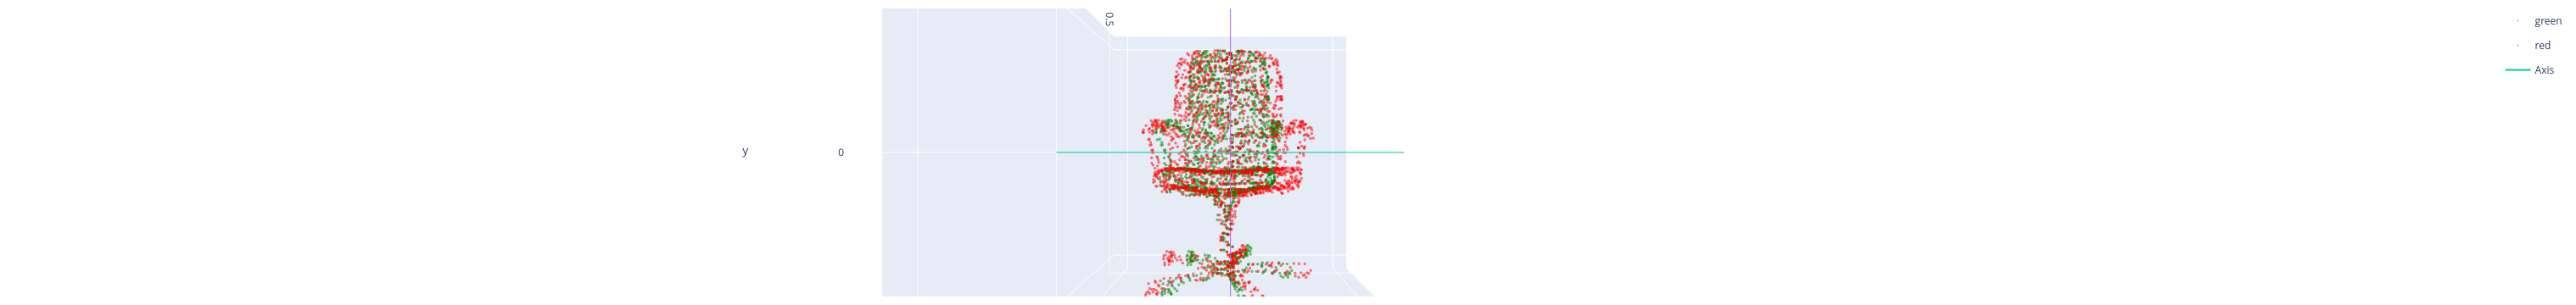

In [15]:
%%time

trans_mat, loss = get_optimal_trans_mat(embeddings, points, iterations=1600)
champ_dist = chamfer_distance_numpy(np.expand_dims(apply_transformation(embeddings, trans_mat), axis=0), np.expand_dims(points, axis=0))
print('Chamfer Distance:', champ_dist)
print('Loss:', loss)
print('EMD:', emd(apply_transformation(embeddings, trans_mat), points))
plot_3D([apply_transformation(embeddings, trans_mat), points], colors=['green', 'red'])

4 Point Alignment: 100%|████████████████| 10000/10000 [00:02<00:00, 4591.09it/s]


1.085774393258393e-05
Chamfer Distance: 0.002171548786516786
EMD: 0.001085774393258393


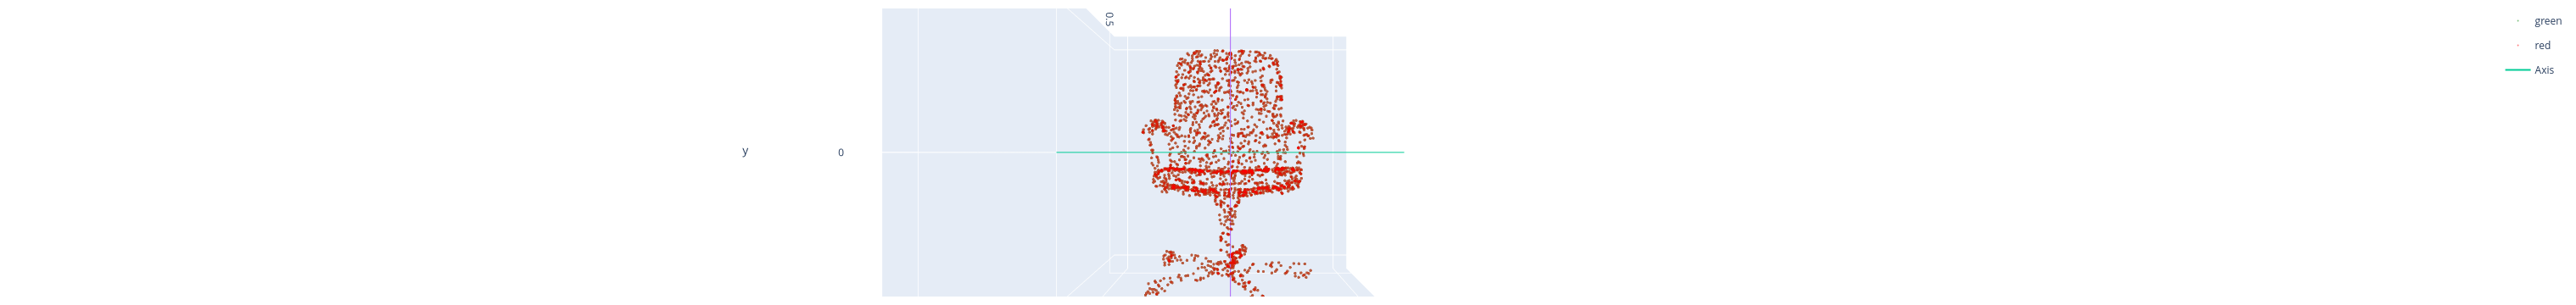

In [16]:
trans_mat, loss = get_4pointsample_transform_mat(embeddings, points)
print(loss)
champ_dist = chamfer_distance_numpy(np.expand_dims(apply_transformation(embeddings, trans_mat), axis=0), np.expand_dims(points, axis=0))
print('Chamfer Distance:', champ_dist)
print('EMD:', emd(apply_transformation(embeddings, trans_mat), points))
plot_3D([apply_transformation(embeddings, trans_mat), points], colors=['green', 'red'])

Loss 0.12227823280011592
Chamfer Distance: 12.69300483952858
EMD: 11.759990049958018


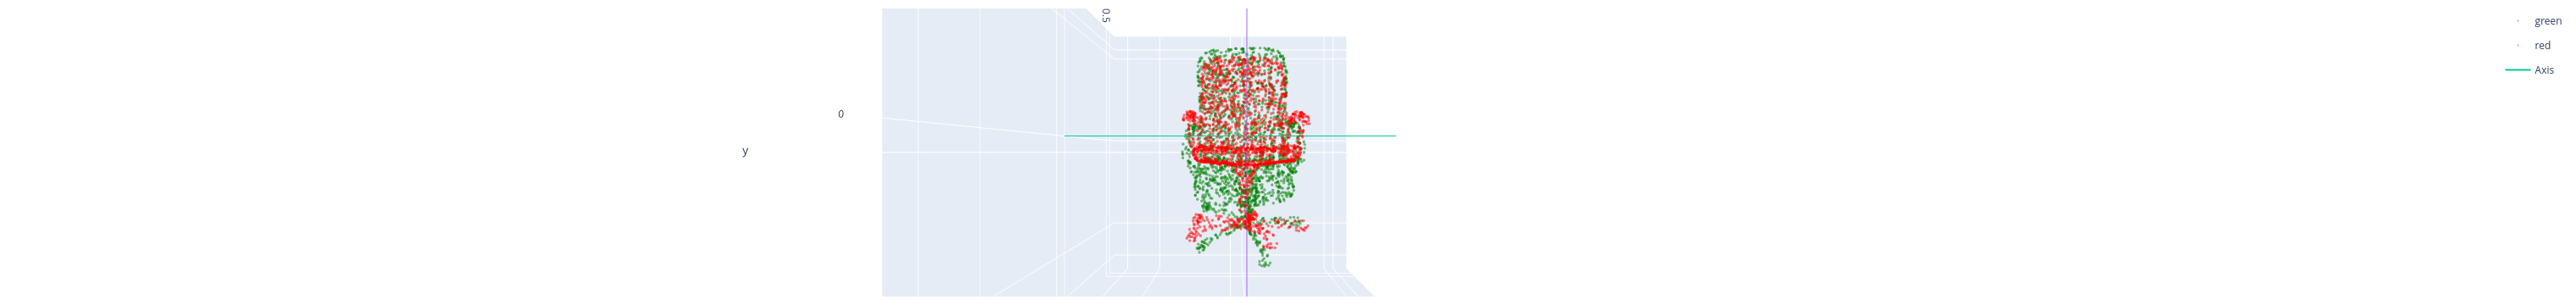

In [17]:
trans_mat, loss = get_svd_trans(embeddings, points)
print('Loss', loss)
champ_dist = chamfer_distance_numpy(np.expand_dims(apply_transformation(embeddings, trans_mat), axis=0), np.expand_dims(points, axis=0))
print('Chamfer Distance:', champ_dist)
print('EMD:', emd(apply_transformation(embeddings, trans_mat), points))
plot_3D([apply_transformation(embeddings, trans_mat), points], colors=['green', 'red'])

In [ ]:
range_x = [
    points[:, 0].min(),
    points[:, 0].max()
]
range_y = [
    points[:, 1].min(),
    points[:, 1].max()
]
range_z = [
    points[:, 2].min(),
    points[:, 2].max()
]

d_th = max([r[1] - r[0] for r in [range_x, range_y, range_z]])

result = get_icp_trans_mat_by_random_rotation(embeddings, points, d_th=d_th, max_iter=1000)
X, Y = result['trans_mat_points_a'], result['trans_mat_points_b']
champ_dist = chamfer_distance_numpy(np.expand_dims(X, axis=0), np.expand_dims(Y, axis=0))
print('Chamfer Distance:', champ_dist)
print('EMD:', emd(X,Y))